In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from aix360.datasets import MEPSDataset


from dalex import explainer


pd.options.display.max_columns = 45

In [3]:
data = MEPSDataset().data()

In [4]:
data.reset_index(drop=True, inplace=True)

In [5]:
data.drop(columns= ['PANEL', 'PERSONWT'], inplace=True)

In [6]:
data = data[data['HEALTHEXP'] < 150000]

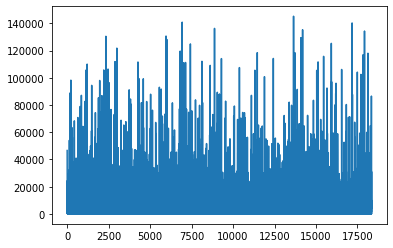

In [7]:
plt.plot(data.HEALTHEXP)


In [8]:
data.head()

,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,RTHLTH31,MNHLTH31,HIBPDX,CHDDX,ANGIDX,MIDX,OHRTDX,STRKDX,EMPHDX,CHBRON31,CHOLDX,CANCERDX,DIABDX,JTPAIN31,ARTHDX,ARTHTYPE,ASTHDX,ADHDADDX,PREGNT31,WLKLIM31,ACTLIM31,SOCLIM31,COGLIM31,DFHEAR42,DFSEE42,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,HEALTHEXP
0,2,52,0.0,0.0,5,13,-1,2,2,4,1,1,1,1,1,1,2,1,2,1,2,1,1,1,3,2,-1,-1,1,1,2,2,2,2,2,25.93,58.47,3,0,4,1,2,11390.0,46612
1,2,55,1.0,0.0,3,14,-1,2,2,4,1,1,2,2,2,2,2,2,2,1,2,1,2,1,3,1,-1,-1,1,1,2,2,2,2,2,20.42,26.57,17,6,4,3,2,11390.0,9207
2,2,22,1.0,0.0,5,13,3,2,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,-1,2,-1,2,2,2,2,2,2,2,2,53.12,50.33,7,0,1,2,2,18000.0,808
3,2,2,0.0,0.0,6,-1,-1,3,3,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,-1,-1,2,-1,2,-1,2,2,-1,-1.00,-1.00,-1,-1,-1,2,2,385.0,2721
4,3,25,1.0,0.0,1,14,-1,2,2,1,3,2,2,2,2,2,2,2,2,2,2,2,1,2,-1,2,-1,1,2,2,2,2,2,2,2,59.89,45.91,9,2,1,3,1,3700.0,1573


In [9]:
def score_r2_print(clf, X_train, X_test, y_train, y_test):
    print('Training R^2:', r2_score(y_train, clf.predict(X_train)))
    print('Test R^2:', r2_score(y_test, clf.predict(X_test)))

# Data preprocessing

In [10]:
cols = data.columns

In [11]:
categoricalCols = [
    'REGION','GENDER', 'RACE3', 'MARRY31X','EDRECODE','FTSTU31X','ACTDTY31','HONRDC31',
    'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX',
    'CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX', 'ARTHTYPE','ASTHDX',
    'ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31','COGLIM31','DFHEAR42',
    'DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15'
]

In [12]:
X, y = data.drop({'HEALTHEXP'}, 1), data['HEALTHEXP']

In [13]:
X_cat = X.copy()
for cat in categoricalCols:
    X_cat[cat] = X_cat[cat].astype('category')

In [14]:
X_copied = X.copy()
X_copied['REGION'] = X_copied['REGION'].map({i: 'REGION_' + str(i) for i in range(1, 5)})
X_copied['MARRY31X'] = X_copied['MARRY31X'].map({i: 'MARRY31X_' + str(i) for i in range(1, 11)})
X_copied['GENDER'] = X_copied['GENDER'].map({0: 'MALE', 1: 'FEMALE'})
X_copied['RACE3'] = X_copied['RACE3'].map({0: 'RACE_0', 1: 'RACE_1'})
X_copied['EDRECODE'] = X_copied['EDRECODE'].map({-1: "EDRECODE_INAPPLICABLE", 1: 'EDRECODE_LSEQ_8TH_GRADE', 2: 'EDRECODE_9-12TH_GRAD', 13: 'EDRECODE_GED_OR_GRAD', 14:'EDRECODE_BEYOND_HS_OR_COLLEGE', 15: 'EDRECODE_BACHELOR', 16: 'EDRECODE_HIGHER_DEGREE'})
X_copied['FTSTU31X'] = X_copied['FTSTU31X'].map({-1: 'FTSTU31X_INAPPLICABLE', 1: 'FTSTU31X_FULLTIME', 2: 'FTSTU31X_PARTTIME', 3: 'FTSTU31X_NOT_A_STUDENT'})
X_copied['ACTDTY31'] = X_copied['ACTDTY31'].map({-1: 'ACTDTY31_INAPPLICABLE', 1: 'ACTDTY31_YES', 2 : "ACTDTY31_NO", 3: 'ACTDTY31_INAPPLICABLE_UNDER_16', 4: 'ACTDTY31_INAPPLICABLE_OVER_59'})
X_copied['HONRDC31'] = X_copied['HONRDC31'].map({-1: 'HONRDC31_INAPPLICABLE', 1: 'HONRDC31_YES', 2 : "HONRDC31_NO", 3: 'HONRDC31_INAPPLICABLE_UNDER_16', 4: 'HONRDC31_ACTIVE_DUTY'})
X_copied['ARTHTYPE'] = X_copied['ARTHTYPE'].map({-1: 'ARTHTYPE_INAPPLICABLE', 1: 'ARTHTYPE_RHEUMATOID_ARTHRITIS', 2 : "ARTHTYPE_OSTEOARTHRITIS", 3: 'ARTHTYPE_NOT_SPECIFIED'})
X_copied['POVCAT15'] = X_copied['POVCAT15'].map({ 1: 'POVCAT15_POOR_OR_NEGATIVE', 2 : "POVCAT15_NEAR_POOR", 3: 'POVCAT15_LOW_INCOME', 4: 'POVCAT15_MIDDLE_INCOME', 5: 'POVCAT15_HIGH_INCOME'})
X_copied['INSCOV15'] = X_copied['INSCOV15'].map({1: 'INSCOV15_ANY_PRIVATE', 2: 'INSCOV15_PUBLIC_ONLY', 3: 'INSCOV15_UNINSURED'})


for cat in ['RTHLTH31', 'MNHLTH31', 'PHQ242', 'EMPST31']:
    X_copied[cat] = X_copied[cat].map({i: cat + '_' + str(i) for i in range(1, 7)})
    

for cat in ['HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX',
            'CHBRON31', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN31', 'ARTHDX',
            'ASTHDX', 'ADHDADDX', 'PREGNT31', 'WLKLIM31', 'ACTLIM31',
            'SOCLIM31', 'COGLIM31', 'DFHEAR42', 'DFSEE42', 'ADSMOK42']:
    X_copied[cat] = X_copied[cat].map({-1: cat + "_INAPPLICABLE", 1: cat + "_YES", 2 : cat + "_NO"})

X_copied = pd.get_dummies(X_copied, prefix='', prefix_sep='')

In [15]:
X_copied.head()

,AGE31X,PCS42,MCS42,K6SUM42,INCOME_M,REGION_1,REGION_2,REGION_3,REGION_4,FEMALE,MALE,RACE_0,RACE_1,MARRY31X_1,MARRY31X_10,MARRY31X_2,MARRY31X_3,MARRY31X_4,MARRY31X_5,MARRY31X_6,MARRY31X_7,MARRY31X_8,...,DFSEE42_YES,ADSMOK42_INAPPLICABLE,ADSMOK42_NO,ADSMOK42_YES,PHQ242_1,PHQ242_2,PHQ242_3,PHQ242_4,PHQ242_5,PHQ242_6,EMPST31_1,EMPST31_2,EMPST31_3,EMPST31_4,POVCAT15_HIGH_INCOME,POVCAT15_LOW_INCOME,POVCAT15_MIDDLE_INCOME,POVCAT15_NEAR_POOR,POVCAT15_POOR_OR_NEGATIVE,INSCOV15_ANY_PRIVATE,INSCOV15_PUBLIC_ONLY,INSCOV15_UNINSURED
0,52,25.93,58.47,3,11390.0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
1,55,20.42,26.57,17,11390.0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
2,22,53.12,50.33,7,18000.0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
3,2,-1.00,-1.00,-1,385.0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,25,59.89,45.91,9,3700.0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_copied, y, test_size=0.2, random_state=37)

# 1 Training models


## 1.1. Linear Regression

In [17]:
slr = LinearRegression()

In [18]:
slr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
score_r2_print(slr, X_train, X_test, y_train, y_test)

Training R^2: 0.24469433693454268
Test R^2: 0.19099338340802963


In [20]:
y_test_pred = slr.predict(X_test)
y_train_pred = slr.predict(X_train)

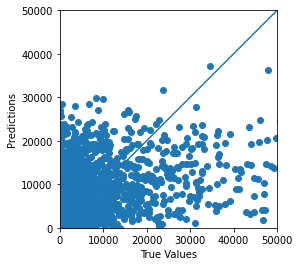

In [21]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## 1.2. Ridge Regression

In [22]:
from sklearn.linear_model import Ridge

In [23]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
score_r2_print(ridge, X_train, X_test, y_train, y_test)

Training R^2: 0.24466621634861008
Test R^2: 0.19144151129170606


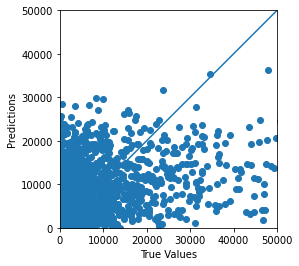

In [24]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, ridge.predict(X_test))
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## 1.3. RandomForestRegressor

In [25]:
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor(
    n_estimators=900, 
    criterion='mse', 
    random_state=1,
    max_features="sqrt",
    n_jobs=-1)
tree.fit(X_train, y_train)
score_r2_print(tree, X_train, X_test, y_train, y_test)


Training R^2: 0.8927740400077464
Test R^2: 0.18285282491194998


## 1.4. GradientBoostingRegressor

In [26]:
gbr = GradientBoostingRegressor(n_estimators=200, random_state=7, max_features="log2")
gbr.fit(X_train, y_train)

score_r2_print(gbr, X_train, X_test, y_train, y_test)

Training R^2: 0.32441228606427686
Test R^2: 0.20092095634569807


In [27]:
y_pred_gbr = gbr.predict(X_test)

In [28]:
test_predictions = gbr.predict(X_test)

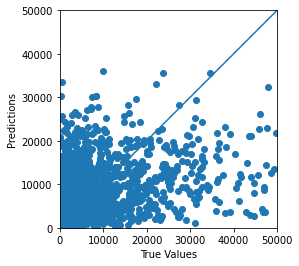

In [29]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## 1.5 NeuralNetwork

In [30]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [31]:
train_stats = X_train.describe()
train_stats = train_stats.transpose()

In [32]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(X_train)
normed_test_data = norm(X_test)

In [33]:
normed_train_data.head()

,AGE31X,PCS42,MCS42,K6SUM42,INCOME_M,REGION_1,REGION_2,REGION_3,REGION_4,FEMALE,MALE,RACE_0,RACE_1,MARRY31X_1,MARRY31X_10,MARRY31X_2,MARRY31X_3,MARRY31X_4,MARRY31X_5,MARRY31X_6,MARRY31X_7,MARRY31X_8,...,DFSEE42_YES,ADSMOK42_INAPPLICABLE,ADSMOK42_NO,ADSMOK42_YES,PHQ242_1,PHQ242_2,PHQ242_3,PHQ242_4,PHQ242_5,PHQ242_6,EMPST31_1,EMPST31_2,EMPST31_3,EMPST31_4,POVCAT15_HIGH_INCOME,POVCAT15_LOW_INCOME,POVCAT15_MIDDLE_INCOME,POVCAT15_NEAR_POOR,POVCAT15_POOR_OR_NEGATIVE,INSCOV15_ANY_PRIVATE,INSCOV15_PUBLIC_ONLY,INSCOV15_UNINSURED
2956,1.097418,0.813209,0.911814,0.327482,1.154849,-0.424779,-0.578276,-0.866013,2.225797,-1.045188,1.045188,0.717236,-0.717236,-0.737739,-0.075911,-0.227258,3.289657,-0.114279,-0.587938,-0.515287,-0.099596,-0.068765,...,-0.182388,-0.688854,0.900646,-0.379776,-0.264852,-0.286623,-0.136974,-0.147699,-0.079899,-0.109912,1.068325,-0.052956,-0.097479,-0.671797,1.445484,-0.409452,-0.637661,-0.234632,-0.486623,0.780499,-0.663681,-0.280162
15045,0.706073,1.103754,0.661609,0.083187,1.027110,2.354006,-0.578276,-0.866013,-0.449247,0.956701,-0.956701,0.717236,-0.717236,-0.737739,-0.075911,-0.227258,-0.303962,-0.114279,1.700743,-0.515287,-0.099596,-0.068765,...,-0.182388,-0.688854,0.900646,-0.379776,-0.264852,-0.286623,-0.136974,-0.147699,-0.079899,-0.109912,1.068325,-0.052956,-0.097479,-0.671797,1.445484,-0.409452,-0.637661,-0.234632,-0.486623,0.780499,-0.663681,-0.280162
405,-0.902790,0.953486,0.984018,-0.405403,-0.548341,-0.424779,-0.578276,1.154638,-0.449247,0.956701,-0.956701,0.717236,-0.717236,-0.737739,-0.075911,-0.227258,-0.303962,-0.114279,1.700743,-0.515287,-0.099596,-0.068765,...,-0.182388,-0.688854,0.900646,-0.379776,-0.264852,-0.286623,-0.136974,-0.147699,-0.079899,-0.109912,1.068325,-0.052956,-0.097479,-0.671797,1.445484,-0.409452,-0.637661,-0.234632,-0.486623,0.780499,-0.663681,-0.280162
13726,0.532142,-0.536006,-0.297894,3.014729,-0.299499,-0.424779,-0.578276,1.154638,-0.449247,-1.045188,1.045188,-1.394146,1.394146,-0.737739,-0.075911,-0.227258,3.289657,-0.114279,-0.587938,-0.515287,-0.099596,-0.068765,...,-0.182388,-0.688854,0.900646,-0.379776,-0.264852,-0.286623,-0.136974,-0.147699,-0.079899,9.097570,-0.935981,-0.052956,-0.097479,1.488444,-0.691762,2.442123,-0.637661,-0.234632,-0.486623,-1.281144,1.506644,-0.280162
1896,0.662590,0.801619,0.820690,-0.405403,0.010283,2.354006,-0.578276,-0.866013,-0.449247,-1.045188,1.045188,0.717236,-0.717236,1.355401,-0.075911,-0.227258,-0.303962,-0.114279,-0.587938,-0.515287,-0.099596,-0.068765,...,-0.182388,-0.688854,0.900646,-0.379776,-0.264852,-0.286623,-0.136974,-0.147699,-0.079899,-0.109912,1.068325,-0.052956,-0.097479,-0.671797,1.445484,-0.409452,-0.637661,-0.234632,-0.486623,0.780499,-0.663681,-0.280162


In [34]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.0001)

model.compile(
    loss='mse',
    optimizer=optimizer,
    metrics=['mae', 'mse', 'msle']
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               18432     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 28,801
Trainable params: 28,801
Non-trainable params: 0
_________________________________________________________________


In [36]:
EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [37]:
history = model.fit(
    normed_train_data, y_train,
    epochs=EPOCHS, 
    validation_split=0.2, 
    verbose=0,
    callbacks=[early_stop]
)

In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,mean_squared_logarithmic_error,val_loss,val_mean_absolute_error,val_mean_squared_error,val_mean_squared_logarithmic_error,epoch
93,1.000578e+08,4537.855469,100057816.0,9.136275,9.431989e+07,4391.781250,94319872.0,9.249764,93
94,9.998775e+07,4558.002930,99987744.0,9.171295,9.437195e+07,4364.193848,94371952.0,9.225927,94
95,1.000218e+08,4525.574219,100021840.0,9.134981,9.435587e+07,4359.711914,94355872.0,9.207378,95
96,9.996971e+07,4524.518555,99969672.0,9.123655,9.434179e+07,4366.408691,94341784.0,9.203906,96
97,9.996196e+07,4525.464355,99961904.0,9.108926,9.432164e+07,4375.137695,94321648.0,9.223455,97


In [39]:
loss, mae, mse, msle = model.evaluate(normed_test_data, y_test, verbose=2)

3666/3666 - 0s - loss: 104981979.3170 - mean_absolute_error: 4665.5034 - mean_squared_error: 104981968.0000 - mean_squared_logarithmic_error: 9.0996


In [40]:
test_predictions = model.predict(normed_test_data).flatten()

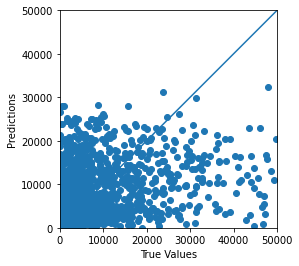

In [41]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [42]:
print('Training R^2:', r2_score(y_train, model.predict(normed_train_data)))
print('Test R^2:', r2_score(y_test, model.predict(normed_test_data)))

Training R^2: 0.24029920986497
Test R^2: 0.18621304787490822


# 2. Calcucate predictions for some selected observations

In [43]:
predictions = (
    pd.DataFrame([y_pred_gbr, y_test])
    .T
    .rename(
        {
            0:"y", 
            1:"y_pred"
        }, 
        axis=1
    )
)
predictions['diff'] = predictions['y'] - predictions['y_pred']
predictions['abs_diff'] = np.abs(predictions['diff'])
obs1_id = predictions.abs_diff.idxmin()
obs1 = predictions.iloc[obs1_id]
obs2_id = predictions['diff'].idxmin()
obs2 = predictions.iloc[obs2_id]
obs3_id = predictions['diff'].idxmax()
obs3 = predictions.iloc[obs3_id]

Minimum difference between prediction and predicted value

In [44]:
obs1

y           0.055936
y_pred      0.000000
diff        0.055936
abs_diff    0.055936
Name: 823, dtype: float64

In [45]:
X_test.iloc[obs1_id]

AGE31X                          42.00
PCS42                           53.17
MCS42                           54.96
K6SUM42                          4.00
INCOME_M                     49920.00
                               ...   
POVCAT15_NEAR_POOR               0.00
POVCAT15_POOR_OR_NEGATIVE        0.00
INSCOV15_ANY_PRIVATE             0.00
INSCOV15_PUBLIC_ONLY             0.00
INSCOV15_UNINSURED               1.00
Name: 1516, Length: 143, dtype: float64

Instance with most overestimated value  between prediction and predicted value

In [46]:
obs2

y            11431.247909
y_pred      136357.000000
diff       -124925.752091
abs_diff    124925.752091
Name: 1019, dtype: float64

In [47]:
X_test.iloc[obs2_id]

AGE31X                          70.0
PCS42                           -1.0
MCS42                           -1.0
K6SUM42                         -1.0
INCOME_M                     16104.0
                              ...   
POVCAT15_NEAR_POOR               0.0
POVCAT15_POOR_OR_NEGATIVE        0.0
INSCOV15_ANY_PRIVATE             1.0
INSCOV15_PUBLIC_ONLY             0.0
INSCOV15_UNINSURED               0.0
Name: 8883, Length: 143, dtype: float64

Instance with most underestimated value  between prediction and predicted value

In [50]:
obs3

y           33495.228721
y_pred        632.000000
diff        32863.228721
abs_diff    32863.228721
Name: 2893, dtype: float64

In [51]:
X_test.iloc[obs3_id]

AGE31X                          75.00
PCS42                           14.08
MCS42                           51.49
K6SUM42                          3.00
INCOME_M                     47684.00
                               ...   
POVCAT15_NEAR_POOR               0.00
POVCAT15_POOR_OR_NEGATIVE        0.00
INSCOV15_ANY_PRIVATE             0.00
INSCOV15_PUBLIC_ONLY             1.00
INSCOV15_UNINSURED               0.00
Name: 12577, Length: 143, dtype: float64

## 3.  Calculate the decomposition of model prediction using Ceteris paribus / ICE profile

In [79]:
from ceteris_paribus.explainer import explain

explainer_gbr = explain(gbr, list(X_test.columns), X_test, y_test)

 You can add label using method set_label


In [133]:
from ceteris_paribus.profiles import individual_variable_profile

cp_profile = individual_variable_profile(explainer_gbr, X_test.iloc[obs2_id], y=obs2['y'])

In [134]:
from ceteris_paribus.plots.plots import plot

plot(cp_profile, selected_variables=["INCOME_M"], inline=True)

<img src="img/img3_1.png">

Selected feature is the __INCOME_M__ feature, which is a yearly income of some selected person. It starts to influence the outcome of the model, when > 200k yearly. Below that value the cost stays almost the same.

## 4. Find two observations in the data set, such that they have different CP profiles

In [108]:
explainer_gbr = explain(gbr, list(X_test.columns), X_test, y_test)

 You can add label using method set_label


In [142]:
sample = select_sample(X_test, n=11)
cp2 = individual_variable_profile(explainer_gbr, sample, variables=["INCOME_M", "AGE31X"])
plot(cp2)

In [146]:
x1 = sample.iloc[9]
x1

AGE31X                          50.0
PCS42                           -1.0
MCS42                           -1.0
K6SUM42                         -1.0
INCOME_M                     28766.0
                              ...   
POVCAT15_NEAR_POOR               0.0
POVCAT15_POOR_OR_NEGATIVE        0.0
INSCOV15_ANY_PRIVATE             1.0
INSCOV15_PUBLIC_ONLY             0.0
INSCOV15_UNINSURED               0.0
Name: 9, Length: 143, dtype: float64

In [148]:
cp_1 = individual_variable_profile(explainer_gbr, x1, variables=["AGE31X"])
plot(cp_1)

<img src="img/img4_1.png">

In [151]:
sample.iloc[1]

AGE31X                       13.0
PCS42                        -1.0
MCS42                        -1.0
K6SUM42                      -1.0
INCOME_M                      0.0
                             ... 
POVCAT15_NEAR_POOR            0.0
POVCAT15_POOR_OR_NEGATIVE     0.0
INSCOV15_ANY_PRIVATE          0.0
INSCOV15_PUBLIC_ONLY          1.0
INSCOV15_UNINSURED            0.0
Name: 1, Length: 143, dtype: float64

In [150]:
cp_2 = individual_variable_profile(explainer_gbr, sample.iloc[1], variables=["AGE31X"])
plot(cp_2)

<img src="img/img4_2.png">

For those two selected instances and feature __AGE31X__ there is a difference in the influence on the model. For the first instance, when age is > 30 the costs drop, where for the second instance costs start to increase after age of 50.

## 5. Train a second model (of any class, neural nets, linear, other boosting) and find an observation for which CP profiles are different between the models

In [107]:
explainer_slr = explain(slr, list(X_test.columns), X_test, y_test)

 You can add label using method set_label


In [111]:
cp_profile_slr = individual_variable_profile(explainer_slr, X_train.iloc[57], y=y_train.iloc[57])
plot(cp_profile_slr, selected_variables=["INCOME_M", "AGE31X"], inline=True)

In [115]:
X_train.iloc[57]

AGE31X                       13.0
PCS42                        -1.0
MCS42                        -1.0
K6SUM42                      -1.0
INCOME_M                      0.0
                             ... 
POVCAT15_NEAR_POOR            0.0
POVCAT15_POOR_OR_NEGATIVE     0.0
INSCOV15_ANY_PRIVATE          1.0
INSCOV15_PUBLIC_ONLY          0.0
INSCOV15_UNINSURED            0.0
Name: 15780, Length: 143, dtype: float64

Linear Regression

<img src="img/img5_slr.png">

Gradient Boosting Regression

<img src="img/img5_gbr.png">

For this instance the influence of features __INCOME_M__ and __AGE31X__ is different between models. For Linear Regression there is no influence on the result, but for Gradient Boosting Regressor there is influence of those features on the predicted outcome.